In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
#import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
import anndata

In [6]:
%%R
library(edgeR)
#library(MAST)

In [18]:
adata = sc.read('breast_tumor.h5ad')

In [ ]:
adata_nk = sc.read('all_nk_cells.h5ad')

In [20]:
adata.obs['label'] = adata.obs['level2_cell_type']

In [21]:
adata.obs['replicate'] = adata.obs['dataset']

In [26]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [27]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")

In [29]:
anndata2ri.activate()

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [34]:
%%R
library(CellChat)

In [49]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [50]:
sc.pp.log1p(adata)

In [53]:
%%R -i adata
adata

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/anndata2ri/py2r.py:37: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


class: SingleCellExperiment 
dim: 15298 445266 
metadata(3): label_colors level2_cell_type_colors log1p
assays(1): X
rownames(15298): C1orf122 COX4I1 ... IZUMO2 FAT2
rowData names(0):
colnames(445266): ACCAACCATGGG_GSM5457202_B2019_GSM5457202_B2019
  CGTTTCCTAGCT_GSM5457202_B2019_GSM5457202_B2019 ...
  BIOKEY_24_Pre_TTTGTCAGTGCAGACA-1_BIOKEY_24_BIOKEY_24
  BIOKEY_24_Pre_TTTGTCAGTGCGGTAA-1_BIOKEY_24_BIOKEY_24
colData names(19): sample patient ... label replicate
reducedDimNames(2): UMAP PCA
mainExpName: NULL
altExpNames(0):


In [54]:
%%R
assayNames(adata) <- c('logcounts')

In [55]:
%%R
assayNames(adata)

[1] "logcounts"


In [56]:
%%R
cellchat <- createCellChat(adata, group.by='label')

[1] "Create a CellChat object from a SingleCellExperiment object"
The `logcounts` assay is used 
The `colData` assay in the SingleCellExperiment object is used as cell meta information 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  1 2 3 4 5 6 B cells CAFs Cancer Basal SC Cancer Cycling Cancer LumA SC Dendritic cells Endothelial cells ILCs Late erythroid Luminal Progenitors Macrophages Mast cells Mature Luminal Memory B cells Monocytes Myoepithelial NKT cells PVL Differentiated Plasma cells Regulatory T cells Tcm/Naive helper T cells Tem/Effector helper T cells Tem/Trm cytotoxic T cells 


In [58]:
%%R
cellchat

An object of class CellChat created from a single dataset 
 15298 genes.
 445266 cells. 
CellChat analysis of single cell RNA-seq data! 


In [59]:
%%R
CellChatDB <- CellChatDB.human

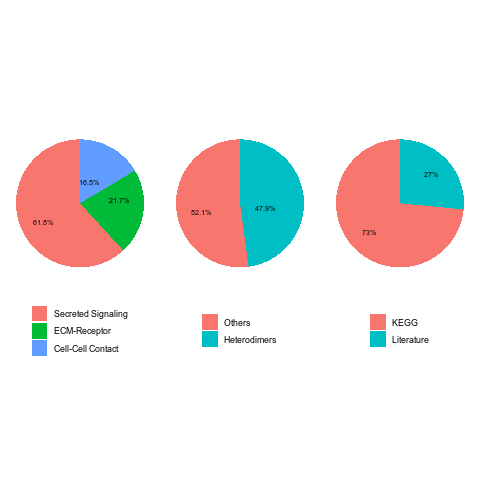

In [60]:
%%R
showDatabaseCategory(CellChatDB)

In [61]:
%%R
CellChatDB.use <- CellChatDB

In [62]:
%%R
cellchat@DB <- CellChatDB.use

In [ ]:
%%R
cellchat <- subsetData(cellchat)
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
#cellchat <- projectData(cellchat, PPI.human)

In [64]:
%%R
cellchat <- computeCommunProb(cellchat)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-09-21 00:06:48]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-09-21 01:07:51]"


In [65]:
%%R
cellchat <- filterCommunication(cellchat, min.cells = 10)

In [66]:
%%R
cellchat <- computeCommunProbPathway(cellchat)

In [67]:
%%R
cellchat <- aggregateNet(cellchat)

In [57]:
%%R
saveRDS(cellchat, file = "cellchat_breast_groups.rds")

In [69]:
%%R
cellchat

An object of class CellChat created from a single dataset 
 15298 genes.
 445266 cells. 
CellChat analysis of single cell RNA-seq data! 


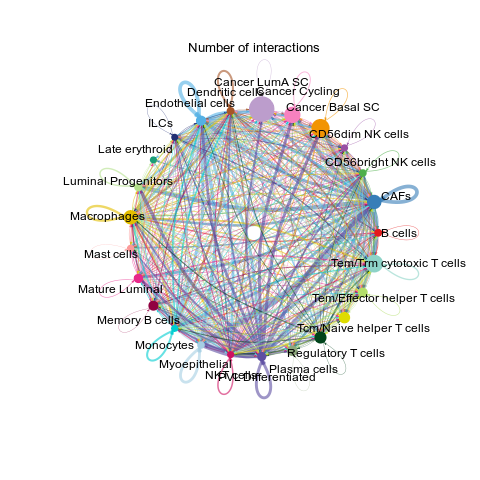

In [61]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#svglite(file ="number_of_interactions_all_glio.svg")
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
#netVisual_circle(cellchat@net$weight, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#ggsave('number_of_interactions_cd56bright_cd56dim_as_targets.pdf')
#dev.off()

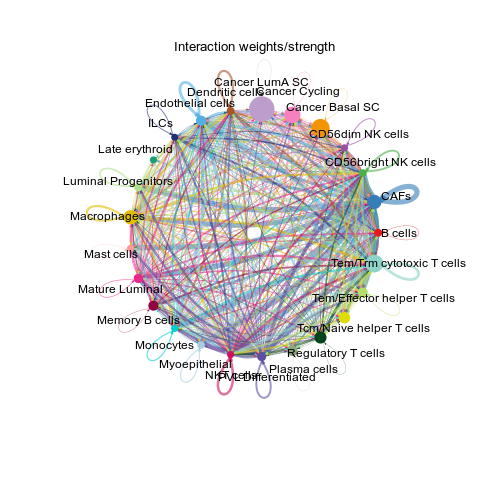

In [62]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#svglite(file ="interaction_weights_all_glio.svg")
#netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#ggsave('number_of_interactions_cd56bright_cd56dim_as_targets.pdf')
#dev.off()

In [ ]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#svglite(file ="number_of_interactions_cd56bright_cd56dim_as_targets_glio.svg")
netVisual_circle(cellchat@net$count, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
#netVisual_circle(cellchat@net$weight, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#ggsave('number_of_interactions_cd56bright_cd56dim_as_targets.pdf')
#dev.off()

In [ ]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#netVisual_circle(cellchat@net$count, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
#svglite(file ="interaction_weights_cd56bright_cd56dim_as_targets_glio.svg")
netVisual_circle(cellchat@net$weight, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#dev.off()
#ggsave('interaction_weights_cd56bright_cd56dim_as_targets.pdf')

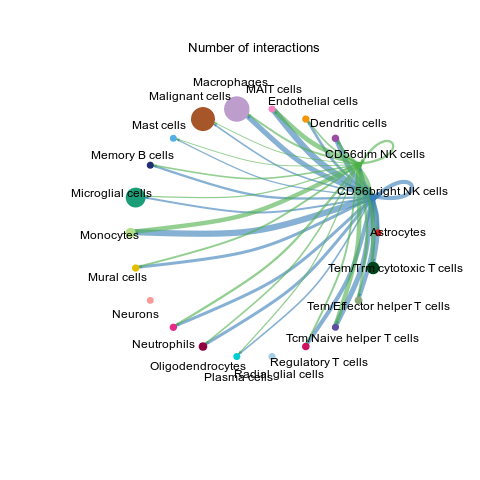

In [32]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#svglite(file ="number_of_interactions_cd56bright_cd56dim_as_sources_glio.svg")
netVisual_circle(cellchat@net$count, sources.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
#netVisual_circle(cellchat@net$weight, sources.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#dev.off()
#ggsave('number_of_interactions_cd56bright_cd56dim_as_sources.pdf')

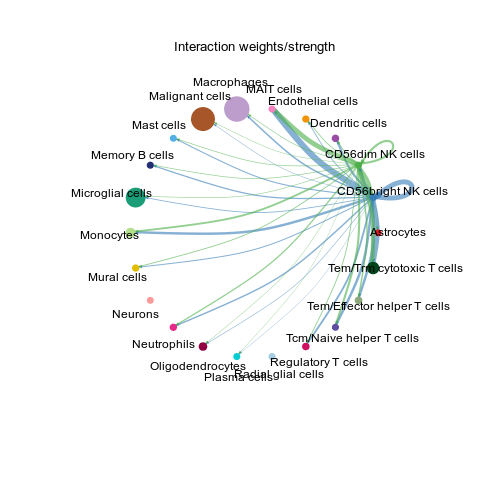

In [34]:
%%R
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,1), xpd=TRUE)
#netVisual_circle(cellchat@net$count, targets.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
#svglite(file ="interaction_weights_cd56bright_cd56dim_as_sources_glio.svg")
netVisual_circle(cellchat@net$weight, sources.use=c(2,3), vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")
#dev.off()
#ggsave('interaction_weights_cd56bright_cd56dim_as_sources.pdf')

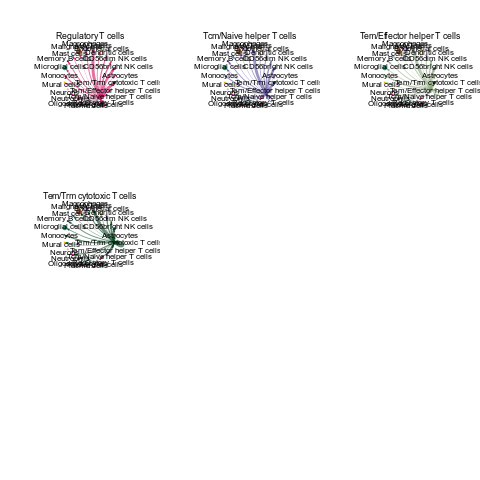

In [35]:
%%R
mat <- cellchat@net$weight
par(mfrow = c(3,3), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

### CXCL

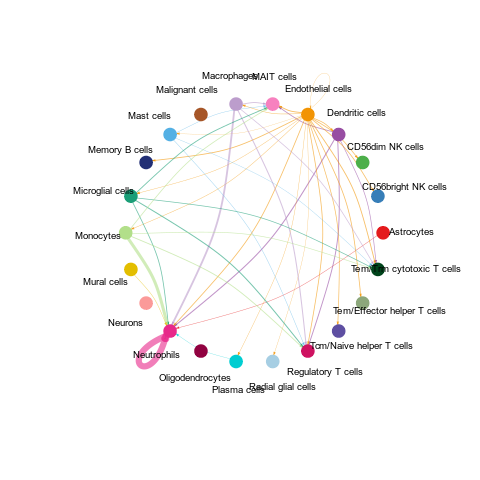

In [36]:
%%R
pathways.show <- c("CXCL") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
#par(mfrow=c(1,1))
#svglite(file ="CXCL_pathway_netvisual_aggregate_circle_glio.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#dev.off()
#ggsave('CXCL_pathway_netvisual_aggregate_circle.pdf')

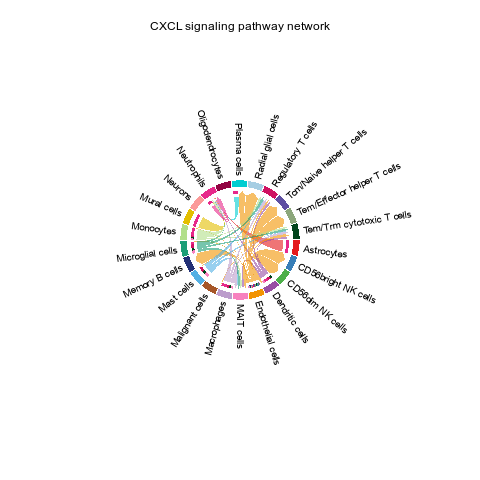

In [37]:
%%R
# Chord diagram
par(mfrow=c(1,1))
#svglite(file ="CXCL_pathway_netvisual_aggregate_chord_glio.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
#dev.off()

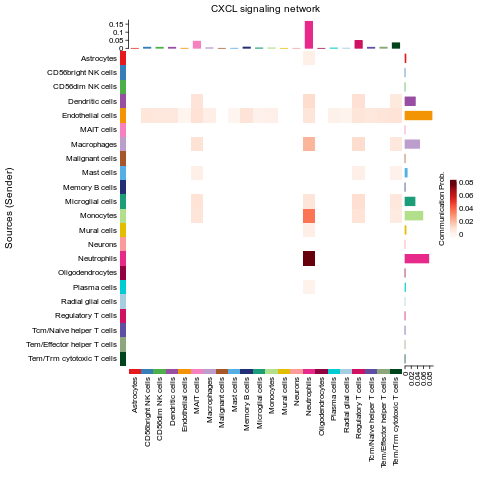

In [38]:
%%R
# Heatmap
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap = "Reds")
#> Do heatmap based on a single object
#ggsave('CXCL_pathway_netvisual_heatmap_glio.pdf')

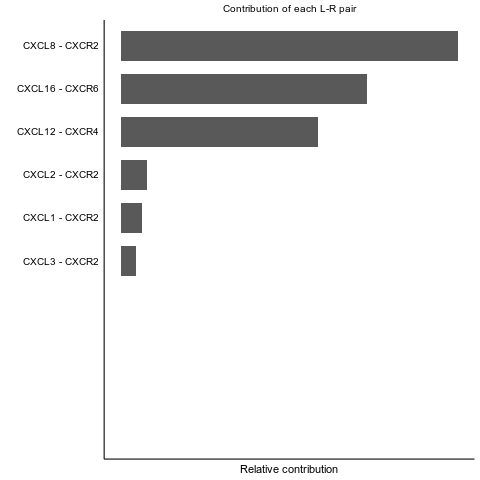

In [39]:
%%R
netAnalysis_contribution(cellchat, signaling = pathways.show)
#ggsave('CXCL_pathway_contribution_glio.pdf')

In [ ]:
%%R
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[4,] # show one ligand-receptor pair
# Hierarchy plot
vertex.receiver = seq(1,4) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
#> [[1]]
# Circle plot
svglite(file ="CXCL12_CXCR4_glio.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")
#ggsave('CXCL12_CXCR4.pdf')
dev.off()

In [ ]:
%%R
svglite(file ="CXCL12_CXCR4_chord_glio.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "chord")
dev.off()

In [ ]:
%%R
netVisual_bubble(cellchat, targets.use = c(2,3), signaling = c("CXCL"), remove.isolate = FALSE)
ggsave('cxcl12_cxcr4_nk_cells_bubble.pdf')

In [ ]:
%%R
plotGeneExpression(cellchat, signaling = "CXCL")
ggsave('CXCL_gene_expression.pdf')

In [ ]:
%%R
# Compute the network centrality scores
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways
# Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
svglite(file ="CXCL_sig_pathway_role_network.svg")
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10)
#ggsave('CXCL_sig_pathway_role_network.pdf')
dev.off()

### CCL

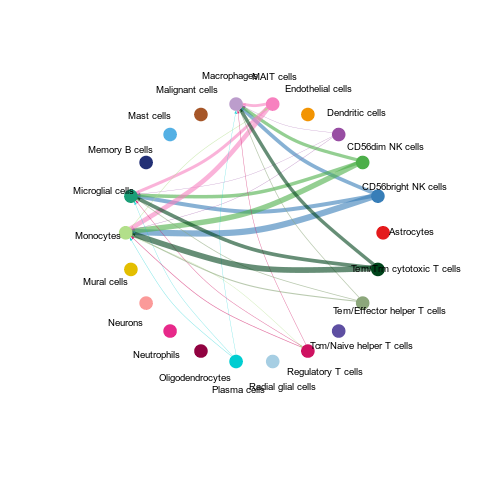

In [40]:
%%R
pathways.show <- c("CCL") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
par(mfrow=c(1,1))
#svglite(file ="CCL_pathway_netvisual_aggregate_circle.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#dev.off()
#ggsave('CCL_pathway_netvisual_aggregate_circle.pdf')

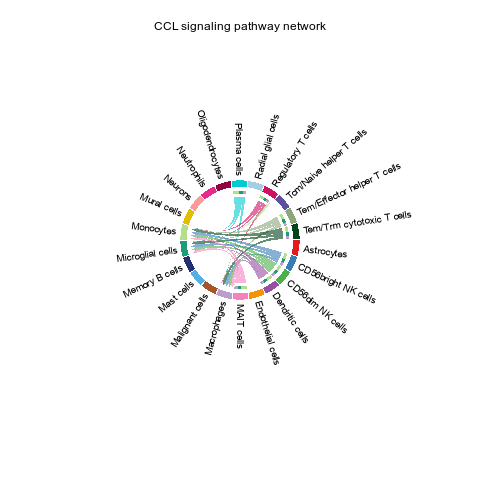

In [41]:
%%R
# Chord diagram
par(mfrow=c(1,1))
#svglite(file ="CCL_pathway_netvisual_aggregate_chord.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
#dev.off()
#ggsave('CCL_pathway_netvisual_aggregate_chord.pdf')

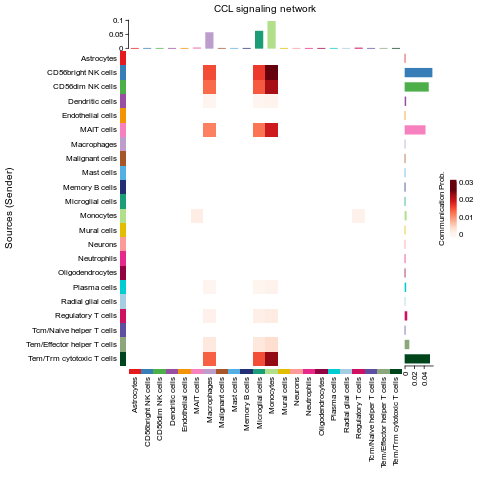

In [42]:
%%R
# Heatmap
par(mfrow=c(1,1))
#svglite(file ="CCL_pathway_netvisual_heatmap.svg")
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap = "Reds")
#dev.off()

#> Do heatmap based on a single object
#ggsave('CCL_pathway_netvisual_heatmap.pdf')

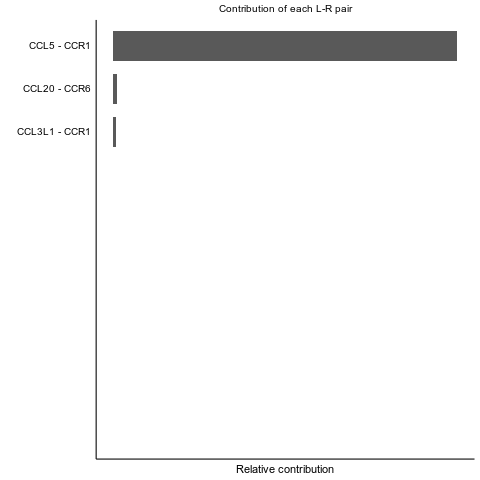

In [46]:
%%R
netAnalysis_contribution(cellchat, signaling = pathways.show)
#ggsave('CCL_pathway_contribution.pdf')

[[1]]



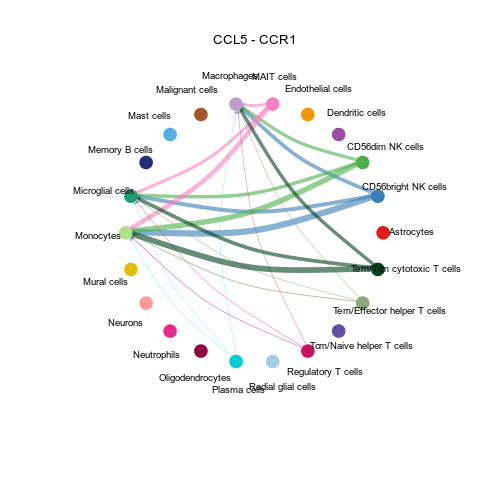

In [47]:
%%R
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[1,] # show one ligand-receptor pair
# Hierarchy plot
vertex.receiver = seq(1,4) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
#> [[1]]
# Circle plot
#svglite(file ="CCL5_CCR1.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")
#dev.off()

#ggsave('CCL5_CCR1.pdf')

[[1]]



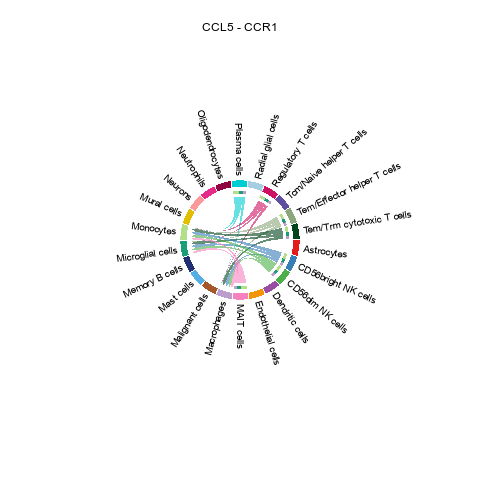

In [48]:
%%R
#svglite(file ="CCL5_CCR1_chord.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "chord")
#dev.off()

#ggsave('CCL5_CCR1_chord.pdf')

In [99]:
%%R
netVisual_bubble(cellchat, sources.use = c(2,3), signaling = c("CCL"), remove.isolate = FALSE)
ggsave('ccl_nk_cells_bubble.pdf')

Saving 6.67 x 6.67 in image


In [168]:
%%R
plotGeneExpression(cellchat, signaling = "CCL")
ggsave('CCL_gene_expression.pdf')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 6.67 x 6.67 in image


In [169]:
%%R
# Compute the network centrality scores
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways
# Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
svglite(file ="CCL_sig_pathway_role_network.svg")
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10)
dev.off()

#ggsave('CCL_sig_pathway_role_network.pdf')

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~01s           |+++                                               | 5 % ~03s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~03s           |+++++++                                           | 14% ~02s           |++++++++                                          | 16% ~02s           |++++++++++                                        | 18% ~02s           |+++++++++++                                       | 20% ~02s           |++++++++++++                                      | 23% ~02s           |+++++++++++++                                     | 25% ~02s           |++++++++++++++                                    | 27% ~01s           |+++++++++++++++                                   | 30% ~01s 

### MHC-I

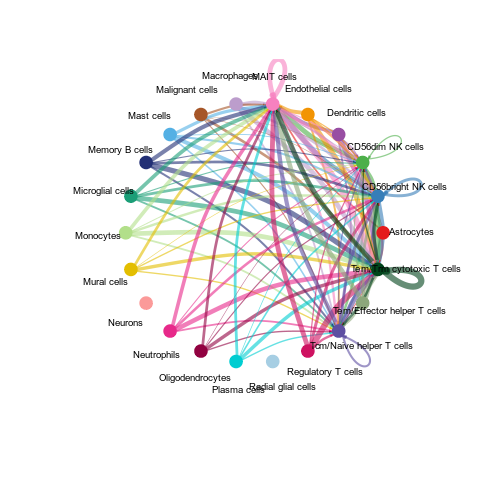

In [49]:
%%R
pathways.show <- c("MHC-I") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
#svglite(file ="a.pdf")
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
#par(mfrow=c(1,1))
#svglite(file ="MHC_I_pathway_netvisual_aggregate_circle.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#ggsave('MHC_I_pathway_netvisual_aggregate_circle.pdf')
#dev.off()

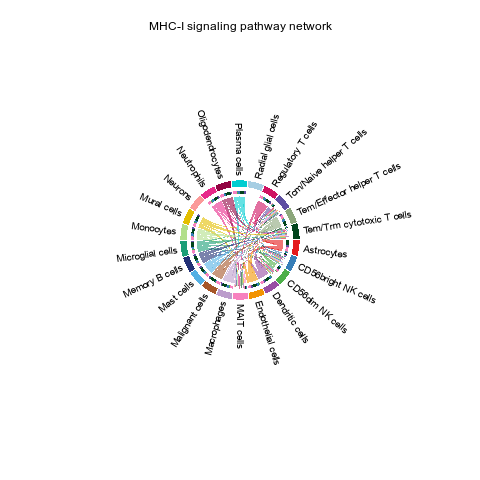

In [50]:
%%R
# Chord diagram
par(mfrow=c(1,1))
#svglite(file ="MHC_I_pathway_netvisual_aggregate_chord.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord")
#dev.off()
#ggsave('MHC_I_pathway_netvisual_aggregate_chord.pdf')

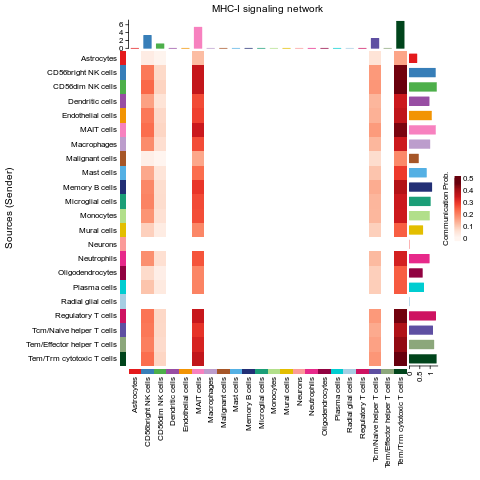

In [51]:
%%R
# Heatmap
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap = "Reds")
#> Do heatmap based on a single object
#ggsave('MHC_I_pathway_netvisual_heatmap.pdf')

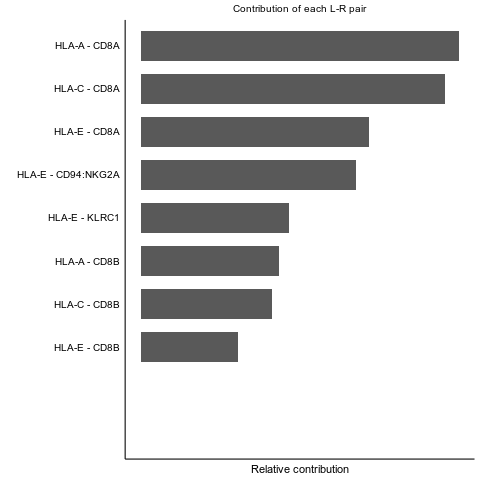

In [52]:
%%R
netAnalysis_contribution(cellchat, signaling = pathways.show)#, return.data=TRUE)
#ggsave('MHC_I_pathway_contribution.pdf')

In [213]:
%%R
mhc_cont$LR.contribution$name

 [1] HLA-E - CD94:NKG2A HLA-B - CD8A       HLA-A - CD8A       HLA-E - KLRC1     
 [5] HLA-C - CD8A       HLA-B - CD8B       HLA-A - CD8B       HLA-C - CD8B      
 [9] HLA-E - CD8A       HLA-E - CD8B       HLA-F - CD8A       HLA-F - CD8B      
12 Levels: HLA-E - CD94:NKG2A HLA-B - CD8A HLA-A - CD8A ... HLA-F - CD8B


In [53]:
%%R
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
pairLR.CXCL

  interaction_name
1       HLA-A_CD8A
2       HLA-C_CD8A
3       HLA-E_CD8A
4       HLA-A_CD8B
5       HLA-C_CD8B
6       HLA-E_CD8B
7      HLA-E_KLRC1
8 HLA-E_CD94:NKG2A


[[1]]



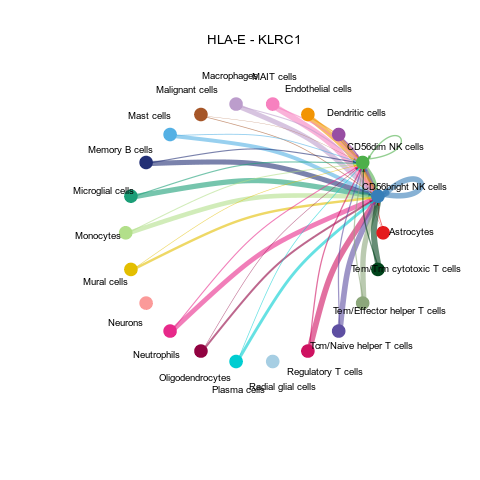

In [55]:
%%R
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[7,] # show one ligand-receptor pair
# Hierarchy plot
vertex.receiver = seq(1,4) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
#> [[1]]
# Circle plot
#svglite(file ="HLA_E_KLRC1.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")
#dev.off()
#ggsave('HLA_E_KLRC1.pdf')

[[1]]



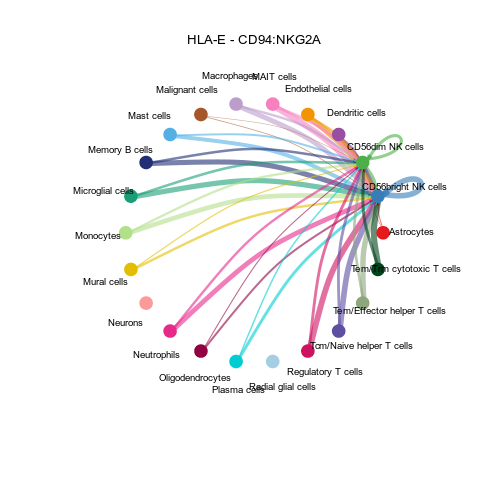

In [56]:
%%R
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[8,] # show one ligand-receptor pair
# Hierarchy plot
vertex.receiver = seq(1,4) # a numeric vector
netVisual_individual(cellchat, signaling = pathways.show,  pairLR.use = LR.show, vertex.receiver = vertex.receiver)
#> [[1]]
# Circle plot
#svglite(file ="HLA_E_CD94.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")
#dev.off()
#ggsave('HLA_E_CD94.pdf')

In [177]:
%%R
svglite(file ="HLA_E_CD94_chord.svg")
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "chord")
dev.off()
#ggsave('HLA_E_CD94.pdf')

png 
  2 


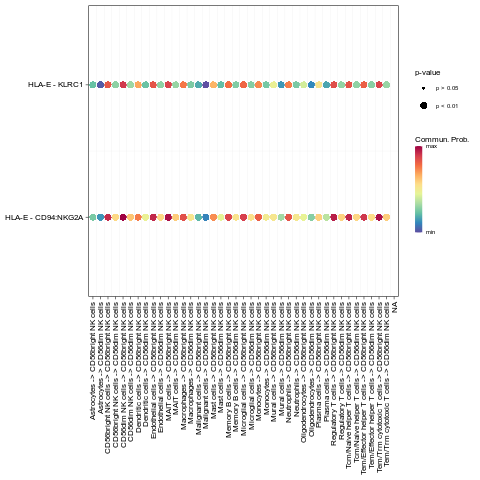

In [57]:
%%R
netVisual_bubble(cellchat, targets.use = c(2,3), signaling = c("MHC-I"), remove.isolate = FALSE)
#ggsave('MHC_I_nk_cells_bubble.pdf')

In [179]:
%%R
plotGeneExpression(cellchat, signaling = "MHC-I")
ggsave('MHC_I_gene_expression.pdf')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Saving 6.67 x 6.67 in image


In [180]:
%%R
# Compute the network centrality scores
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways
# Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
svglite(file ="MHC_I_sig_pathway_role_network.svg")
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10)
dev.off()
#ggsave('MHC_I_sig_pathway_role_network.pdf')

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~02s           |+++                                               | 5 % ~04s           |++++                                              | 7 % ~03s           |+++++                                             | 9 % ~03s           |++++++                                            | 11% ~03s           |+++++++                                           | 14% ~03s           |++++++++                                          | 16% ~03s           |++++++++++                                        | 18% ~02s           |+++++++++++                                       | 20% ~02s           |++++++++++++                                      | 23% ~02s           |+++++++++++++                                     | 25% ~02s           |++++++++++++++                                    | 27% ~02s           |+++++++++++++++                                   | 30% ~02s 

### XCR

In [58]:
%%R
cellchat

An object of class CellChat created from a single dataset 
 26355 genes.
 782101 cells. 
CellChat analysis of single cell RNA-seq data! 


In [59]:
%%R
pathways.show.all <- cellchat@netP$pathways

In [60]:
%%R
pathways.show.all

 [1] "MIF"        "MHC-I"      "SPP1"       "COLLAGEN"   "PTN"       
 [6] "CLEC"       "APP"        "MHC-II"     "FN1"        "GALECTIN"  
[11] "LAMININ"    "ANNEXIN"    "MK"         "PSAP"       "ITGB2"     
[16] "VISFATIN"   "COMPLEMENT" "ADGRE5"     "GRN"        "CD45"      
[21] "ICAM"       "NCAM"       "CXCL"       "IL1"        "EGF"       
[26] "LCK"        "CD22"       "VEGF"       "THY1"       "JAM"       
[31] "SELPLG"     "CCL"        "SELL"       "THBS"       "PARs"      
[36] "PECAM1"     "CLDN"       "CADM"       "MAG"        "FGF"       
[41] "TGFb"       "CD86"       "IL16"       "CD39"       "ESAM"      
[46] "GAS"        "CNTN"       "RESISTIN"   "ALCAM"      "CD6"       
[51] "CDH"        "ANGPTL"     "ANXA1"      "ANGPT"      "NECTIN"    
[56] "BAFF"       "NOTCH"      "EDN"        "CD46"       "SEMA4"     
[61] "OSM"        "SEMA3"      "CSF"        "TIGIT"      "PDGF"      
[66] "VISTA"      "CALCR"      "CD40"       "CD96"       "MPZ"       
[71] "CDH5"       "T

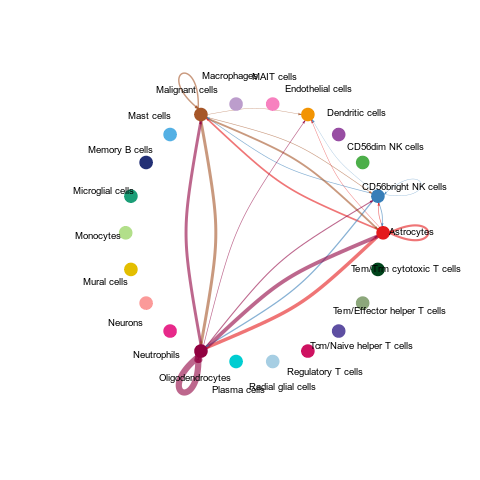

In [65]:
%%R
pathways.show <- c("NCAM") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
#svglite(file ="a.pdf")
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
#par(mfrow=c(1,1))
#svglite(file ="MHC_I_pathway_netvisual_aggregate_circle.svg")
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#ggsave('MHC_I_pathway_netvisual_aggregate_circle.pdf')
#dev.off()

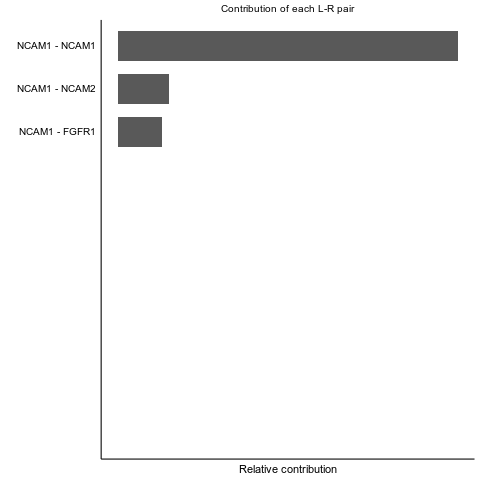

In [66]:
%%R
netAnalysis_contribution(cellchat, signaling = pathways.show)#, return.data=TRUE)
#ggsave('MHC_I_pathway_contribution.pdf')

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


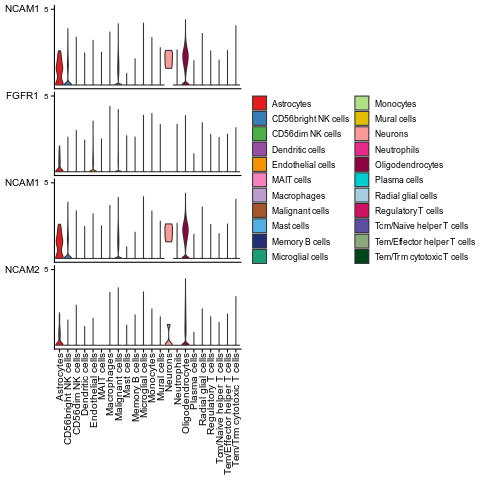

In [67]:
%%R
plotGeneExpression(cellchat, signaling = pathways.show)
#ggsave('MHC_I_gene_expression.pdf')